# SVM Classification

Using [this](https://medium.com/abraia/hyperspectral-image-classification-with-python-7dce4ebcda0a) resource.

and [this](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) documentation from sklearn.

and [this](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions).

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists

from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [2]:
fn = "processed-data/tertiary-capture/reflectance/2022_11_16/33-2nd/2022_11_16-04_10_54.nc"
gnd_t_fn = fn.split('.')[0] + ".pkl"

In [3]:
# Load ground truth
with open(gnd_t_fn, 'rb') as out_file:
    ground_truths = pickle.load(out_file)
    
# Remove erroneous 0 values around edge of image
for i in range(ground_truths.shape[0]):
    for j in range(ground_truths.shape[1]):
        if ground_truths[i,j] == 0:
            ground_truths[i,j] = 1
          
y = ground_truths.copy().reshape(ground_truths.shape[0]*ground_truths.shape[1])  
    
# Load data
ds = nc.Dataset(fn)

# extract the datacube from the dataset
dc = np.array(ds['datacube'])

# Data needs to be x, y, bands instead of bands, x, y.
data = dc.transpose(1,2,0)
X = data.copy().reshape(data.shape[0]*data.shape[1],data.shape[2])

In [4]:
print(y.shape)
print(X.shape)
print(np.bincount(y))

(449536,)
(449536, 131)
[     0 212605  83986  89378  63567]


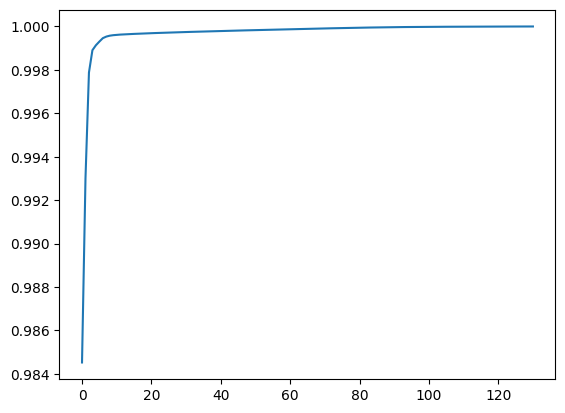

In [5]:
pca = PCA()
pcX = pca.fit_transform(X)
ev = pca.explained_variance_ratio_
cumulativeVar = np.cumsum(ev)
plt.plot(cumulativeVar)

In [6]:
nComp = 5
pca = PCA(n_components=nComp)
pca.fit(X)
pcX = pca.transform(X)

In [7]:
print(pcX.shape)

(449536, 10)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(pcX, y, test_size=0.20, random_state=11, stratify=y)

In [9]:
print(X_train.shape)

(359628, 10)


In [10]:
svm = SVC(C=1, kernel='linear', gamma='scale', shrinking=False)

In [11]:
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', shrinking=False)

In [12]:
y_pred = svm.predict(pcX)

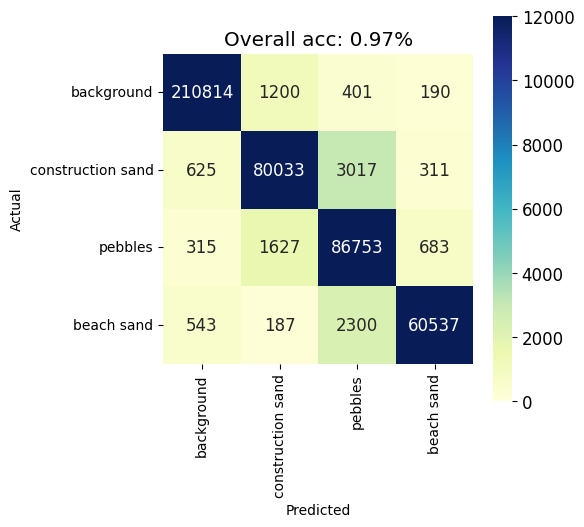

In [13]:
class_labels = ['background', 'construction sand', 'pebbles', 'beach sand']
classes = [1,2,3,4]
 
# multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
cm = confusion_matrix(y, y_pred, labels=classes)

df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plt.rcParams['font.size'] = 12

sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=12000,fmt='d')

ax1.set_title('Overall acc: {:.2f}%'.format(accuracy_score(y, y_pred)))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');

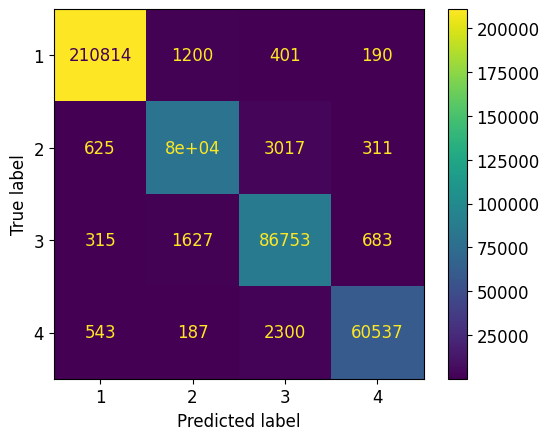

In [14]:
ConfusionMatrixDisplay.from_predictions(y, y_pred)

In [15]:
print(classification_report(y, y_pred, target_names=class_labels))

                   precision    recall  f1-score   support

       background       0.99      0.99      0.99    212605
construction sand       0.96      0.95      0.96     83986
          pebbles       0.94      0.97      0.95     89378
       beach sand       0.98      0.95      0.97     63567

         accuracy                           0.97    449536
        macro avg       0.97      0.97      0.97    449536
     weighted avg       0.97      0.97      0.97    449536



In [18]:
# transform predictions into image shape
class_img = y_pred.reshape(ground_truths.shape)

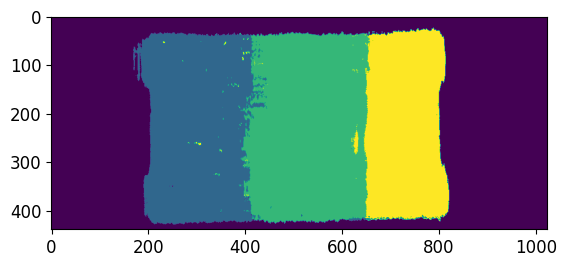

In [19]:
# display image, let plt figure out colours, it will colour each class.
plt.imshow(class_img)

In [20]:
# transform predictions into image shape
gt_img = y.reshape(ground_truths.shape)

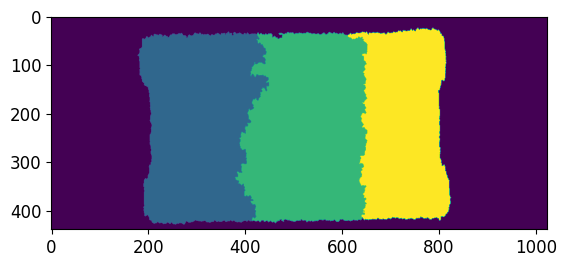

In [21]:
# display image, let plt figure out colours, it will colour each class.
plt.imshow(gt_img)

## Evaluate on a different image.

In [36]:
test_fn = "processed-data/tertiary-capture/reflectance/2022_11_16/33-2nd/2022_11_16-04_11_30.nc"
test_fn_rad = test_fn.replace('reflectance','radiance')
test_gnd_t_fn = fn.split('.')[0] + ".pkl"

In [37]:
# Load ground truth
with open(test_gnd_t_fn, 'rb') as out_file:
    test_gt = pickle.load(out_file)
    
# Remove erroneous 0 values around edge of image
for i in range(test_gt.shape[0]):
    for j in range(test_gt.shape[1]):
        if test_gt[i,j] == 0:
            test_gt[i,j] = 1
            
test_y = test_gt.copy().reshape(test_gt.shape[0]*test_gt.shape[1]) 

In [26]:
# Load data
test_ds = nc.Dataset(test_fn)
test_ds_rad = nc.Dataset(test_fn_rad)

In [27]:
# extract the datacube from the dataset
test_dc = np.array(test_ds['datacube'])

In [28]:
# Data needs to be x, y, bands instead of bands, x, y.
test_data = test_dc.transpose(1,2,0)

In [29]:
# transform into a line of pixels for PCA
test_X = test_data.copy().reshape(test_data.shape[0]*test_data.shape[1],test_data.shape[2])

## Useful Functions

In [30]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube'])
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])
    loc_image = np.zeros((loc_dc.shape[1],loc_dc.shape[2],3), np.uint8)

    loc_red_wavelength = 620
    loc_green_wavelength = 560
    loc_blue_wavelength = 470

    loc_red_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_red_wavelength)),:,:]  
    loc_green_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_green_wavelength)),:,:] 
    loc_blue_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_blue_wavelength)),:,:] 

    # loc_red_layer = loc_dc[120,:,:]  
    # loc_green_layer = loc_dc[80,:,:] 
    # loc_blue_layer = loc_dc[20,:,:] 

    loc_image[:,:,0] = loc_red_layer
    loc_image[:,:,1] = loc_green_layer
    loc_image[:,:,2] = loc_blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    loc_vmax = np.nanpercentile(loc_image, 98)
    loc_vmin = np.nanpercentile(loc_image, 2)
    loc_image = ((loc_image.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
    loc_image = np.minimum(np.maximum(loc_image, 0), 1)

    loc_image *= 255
    loc_image = loc_image.astype(np.uint8)
    
    return loc_image

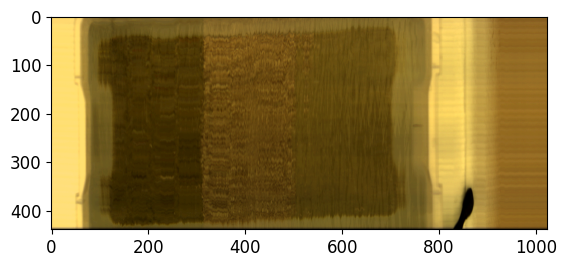

In [31]:
test_img = process_into_rgb(test_ds_rad)
plt.imshow(test_img)

In [32]:
# perform pca on new image
pca.fit(test_X)
test_pcX = pca.transform(test_X)

In [33]:
# make predicitons with classifier
test_test_pred=svm.predict(test_pcX)

In [34]:
# transform predictions into image shape
test_x = test_test_pred.reshape(test_img[:, :, 0].shape)

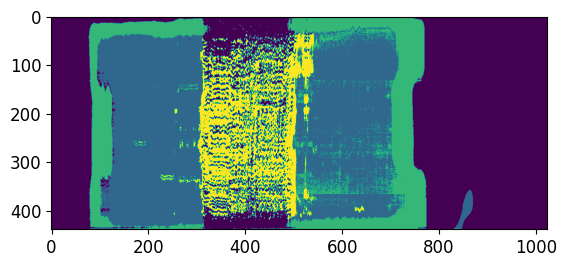

In [35]:
# display image, let plt figure out colours, it will colour each class.
plt.imshow(test_x)

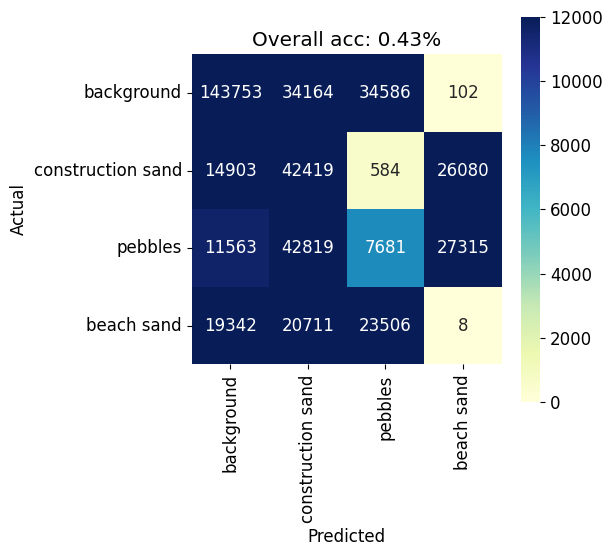

In [38]:
class_labels = ['background', 'construction sand', 'pebbles', 'beach sand']
classes = [1,2,3,4]
 
# multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
cm = confusion_matrix(test_y, test_test_pred, labels=classes)

df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plt.rcParams['font.size'] = 12

sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=12000,fmt='d')

ax1.set_title('Overall acc: {:.2f}%'.format(accuracy_score(test_y, test_test_pred)))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');